In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import make_pipeline
import sys
warnings.filterwarnings(action="ignore")

In [3]:
# local, GoogleColab
place = 'GoogleColab'

# path
# GoogleColab
if place == 'GoogleColab':
    path_input = '/content/drive/MyDrive/Colab Notebooks/ProbSpace/民泊サービスの宿泊料金予測/input'
    path_submission = '/content/drive/MyDrive/Colab Notebooks/ProbSpace/民泊サービスの宿泊料金予測/submission'
    path_stacking = '/content/drive/MyDrive/Colab Notebooks/ProbSpace/民泊サービスの宿泊料金予測/notebook/stacking'
    path_preproc_pl = '/content/drive/MyDrive/Colab Notebooks/ProbSpace/民泊サービスの宿泊料金予測/notebook/preproc_output/pl'

    sys.path.append('/content/drive/MyDrive/Colab Notebooks/my-modules/')

# local
elif place == 'local':
    path_input = '../input'
    path_submission = '../submission'

In [4]:
station_list = pd.read_csv(f"{path_input}/station_list.csv")
train_data = pd.read_csv(f"{path_input}/train_data.csv")
test_data = pd.read_csv(f"{path_input}/test_data.csv")

print(f'station_list : {station_list.shape}')
print(f'train_data : {train_data.shape}')
print(f'test_data : {test_data.shape}')

station_list : (746, 3)
train_data : (9990, 13)
test_data : (4996, 12)


In [5]:
# idとTargetを分ける
# id
train_id = train_data.id
test_id = test_data.id

# target(評価指標がRMSLEのため、対数化)
train_target = np.log1p(train_data.y)

# df
df_train = train_data.drop(columns=["id", "y"])
df_test = test_data.drop(columns="id")

In [6]:
# shape
print("df_train : ", df_train.shape)
print("df_test : ", df_test.shape)

df_train :  (9990, 11)
df_test :  (4996, 11)


## Stacking用pickleをインポート

In [7]:
# path
y_train_path = f"{path_stacking}/y_train.pickle"
y_test_path = f"{path_stacking}/y_test.pickle"
test_id_path = f"{path_preproc_pl}/test_id_path.pickle"

In [8]:
with open(y_train_path, 'rb') as p:
    y_train = pickle.load(p)

with open(y_test_path, 'rb') as p:
    y_test = pickle.load(p)

with open(test_id_path, 'rb') as p:
    test_id = pickle.load(p)

print(f'y_train : {y_train.shape}')
print(f'y_test : {y_test.shape}')
print(f'test_id : {test_id.shape}')

y_train : (7911,)
y_test : (1978,)
test_id : (4996,)


In [9]:
model_list = ['lgb', 'pl']
X_train = pd.DataFrame()
X_test = pd.DataFrame()
X_submit = pd.DataFrame()

for m in model_list:
    with open(f"{path_stacking}/{m}_pred_train.pickle", 'rb') as p:
        X_train[f"{m}_pred"] = pickle.load(p)

    with open(f"{path_stacking}/{m}_pred_test.pickle", 'rb') as p:
        X_test[f"{m}_pred"] = pickle.load(p)

    with open(f"{path_stacking}/{m}_pred_submit.pickle", 'rb') as p:
        X_submit[f"{m}_pred"] = pickle.load(p)

print(f'X_train : {X_train.shape}')
print(f'X_test : {X_test.shape}')
print(f'X_submit : {X_submit.shape}')

X_train : (7911, 2)
X_test : (1978, 2)
X_submit : (4996, 2)


In [10]:
param_grid = {'elasticnet__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
              'elasticnet__l1_ratio': [0.001, 0.01, 0.1, 1]}
print("Parameter grid:\n{}".format(param_grid))

Parameter grid:
{'elasticnet__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10], 'elasticnet__l1_ratio': [0.001, 0.01, 0.1, 1]}


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

model = make_pipeline(StandardScaler(), ElasticNet())
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='neg_root_mean_squared_error')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('elasticnet', ElasticNet())]),
             param_grid={'elasticnet__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1,
                                               1, 10],
                         'elasticnet__l1_ratio': [0.001, 0.01, 0.1, 1]},
             scoring='neg_root_mean_squared_error')

In [12]:
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Test set score: -0.46


In [13]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.001}
Best cross-validation score: -0.50


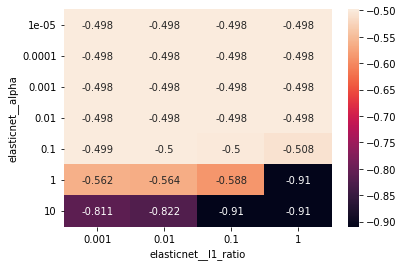

In [14]:
results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(len(param_grid[list(param_grid.keys())[0]]), len(param_grid[list(param_grid.keys())[1]]))

# 平均交差検証スコアのプロット
sns.heatmap(scores, annot=True, fmt='.3g', xticklabels=param_grid[list(param_grid.keys())[1]], yticklabels=param_grid[list(param_grid.keys())[0]])
plt.xlabel(list(param_grid.keys())[1])
plt.ylabel(list(param_grid.keys())[0])
plt.show()

In [15]:
grid_search.best_estimator_['elasticnet'].coef_

array([0.38625472, 0.38897567])

In [16]:
grid_search.best_estimator_['elasticnet'].intercept_

9.431255513486077

サブミット

In [17]:
y_pred = grid_search.best_estimator_.predict(X_submit)

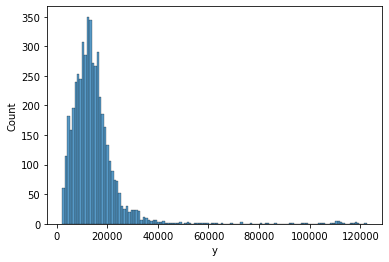

In [18]:
df_submit = pd.DataFrame({"id": test_id, "y": np.expm1(y_pred)})
sns.histplot(df_submit.y)

In [19]:
import datetime

today = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

df_submit.to_csv(f"{path_submission}/{today}.csv", index=False)

## 変数重要度

### lightGBM

In [ ]:
df_fi = pd.DataFrame(
    {"column": X.columns, "feature_importance": best_model.feature_importances_}
).sort_values("feature_importance", ascending=False)
df_fi.tail(20)

column  feature_importance
29                          name_☆|♪|★                  21
128                  name_tfidf_nmf_32                  17
120                  name_tfidf_nmf_24                  16
8                     last_review_year                  10
28                           name_semi                   7
15   category_distance_nearest_station                   6
20               name_luxurious|luxury                   4
30               name_wifi|wi-fi|wi fi                   3
21                          name_suite                   2
27                      name_dormitory                   2
31                           name_cozy                   1
22                         name_direct                   1
26                              name_王                   0
24                           name_美式大床                   0
23                       name_playroom                   0
17                          name_uhome                   0
19                        name_biggest                   0
18                   name_prem|premium                   0
16             cluster_nearest_station                   0
25                            name_sky                   0

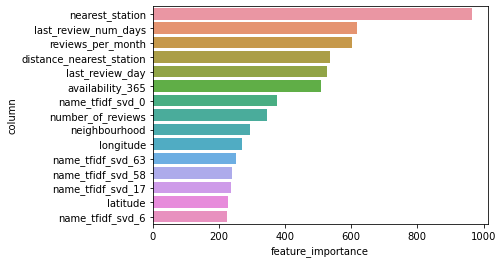

In [ ]:
sns.barplot(data=df_fi.head(15), x="feature_importance", y="column")

plt.show()

### dalex

In [ ]:
import dalex as dx

model_exp = dx.Explainer(best_model, X_train, y_train)

Preparation of a new explainer is initiated

  -> data              : 7911 rows 160 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 7911 values
  -> model_class       : lightgbm.sklearn.LGBMRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x0000026FCC2D5430> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 6.85, mean = 9.43, max = 12.4
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -2.92, mean = 0.00115, max = 2.08
  -> model_info        : package lightgbm

A new explainer has been created!


In [ ]:
mp_model = model_exp.model_parts()

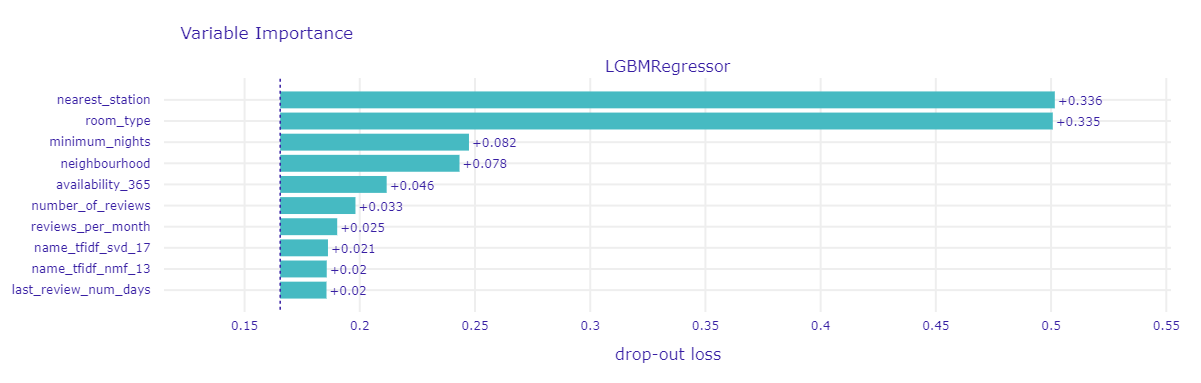

In [ ]:
mp_model.plot()

In [ ]:
mp_model.result.sort_values("dropout_loss", ascending=False)

variable  dropout_loss          label
161               _baseline_      1.266602  LGBMRegressor
160          nearest_station      0.501623  LGBMRegressor
159                room_type      0.500738  LGBMRegressor
158           minimum_nights      0.247382  LGBMRegressor
157            neighbourhood      0.243278  LGBMRegressor
..                       ...           ...            ...
1               name_biggest      0.165459  LGBMRegressor
6                  name_美式大床      0.165459  LGBMRegressor
7               _full_model_      0.165459  LGBMRegressor
8    cluster_nearest_station      0.165459  LGBMRegressor
0                   name_sky      0.165459  LGBMRegressor

[162 rows x 3 columns]